In [2]:
import cv2 
import numpy as np
import matplotlib.pylab as plt
import math 

def showC(img):
    rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(rgb,cmap="gray")
    
def show(img):
    plt.imshow(img,cmap="gray")

In [3]:
def threshold_range(img, T1, T2):
    _,th1 = cv2.threshold(img, T1,255, cv2.THRESH_BINARY_INV)
    _,th2 = cv2.threshold(img, T2,255, cv2.THRESH_BINARY_INV)
    
    th_range = cv2.bitwise_xor(th1,th2)
    
    return th_range

# **Sobel** 

In [4]:
kernel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

kernel_y = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
])


crop = np.array([
    [2,3,5],
    [6,4,1],
    [9,12,2],
])


In [5]:
mutil = np.multiply(kernel_y,crop )
new_value = np.sum(mutil)
print(new_value)

22


In [6]:
def add_padding(img, padding = 1):

    new_height = img.shape[0] + 2*padding
    new_width = img.shape[1] + 2*padding
    
    new_image = np.zeros((new_height,new_width), dtype = np.uint8)
    new_image [padding:new_height - padding ,   padding:new_width - padding] = img
    
    
    return new_image

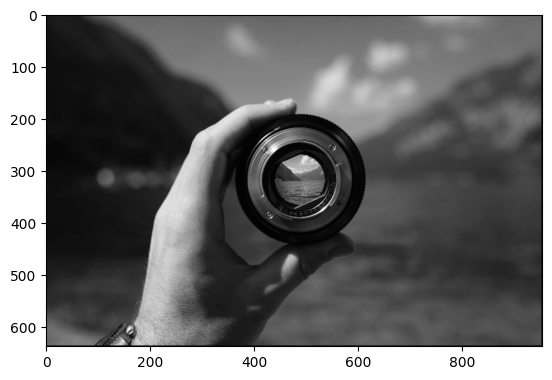

In [7]:
gray = cv2.imread("images/lens.png",0 )
gray_padding = add_padding(gray, 1)
show(gray_padding)

In [8]:
def sobel(img, kernel, data_type = np.uint8):
    
    height = img.shape[0]
    width  = img.shape[1]
    
    padding = kernel.shape[0] // 2
    
    img_padding = add_padding(img, padding)
    img_padding = img_padding.astype(data_type)
    
    sobel_space = np.zeros((img.shape), dtype = data_type)
    
    for y in range(padding ,height + padding):
        for x in range(padding ,width + padding):
            
            crop = img_padding [y- padding: y+padding +1  , x- padding: x+padding +1]
            mutil = np.multiply(kernel,crop)
            gradient = np.sum(mutil)
            
            sobel_space[y - padding , x - padding] = gradient
        
    
    return sobel_space

-742.0
867.0


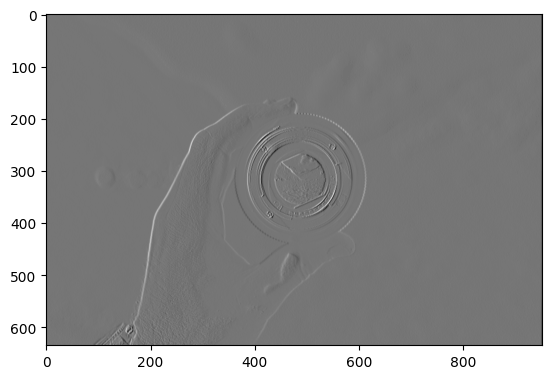

In [9]:
sobel_space = sobel(gray, kernel_x, data_type = np.float64)
show(sobel_space)
print(np.min(sobel_space))
print(np.max(sobel_space))

## Edge Negative

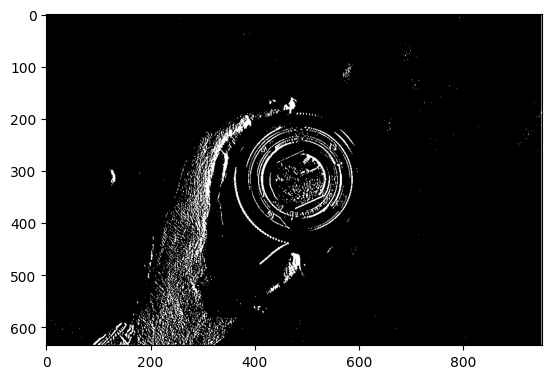

In [10]:
_, edge_negative = cv2.threshold(sobel_space, -30 , 255, cv2.THRESH_BINARY_INV)
#edge_negative = threshold_range(sobel_space, 10,40)
show(edge_negative)

## Edge Positive

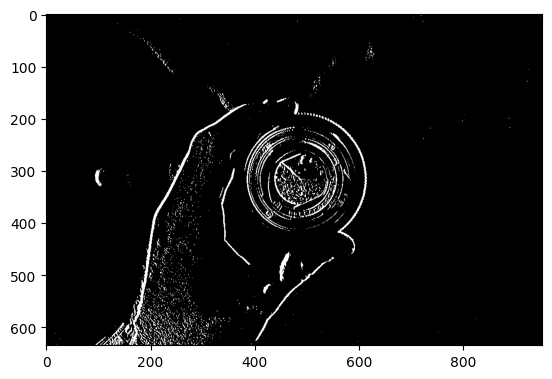

In [11]:
_, edge_positive = cv2.threshold(sobel_space, 30 , 255, cv2.THRESH_BINARY)
#edge_positive = threshold_range(sobel_space, 100,180)

show(edge_positive)

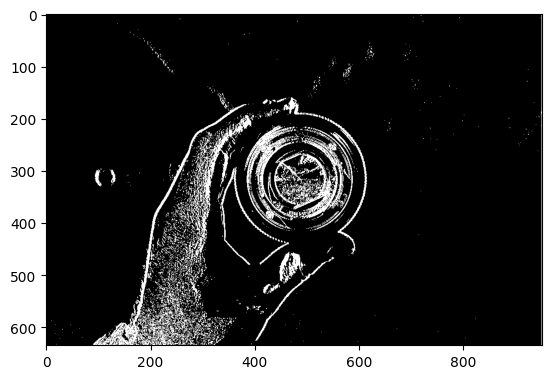

In [12]:
edge_ox  = cv2.bitwise_or(edge_positive, edge_negative)
show(edge_ox)

## Sobel Oy

-861.0
882.0


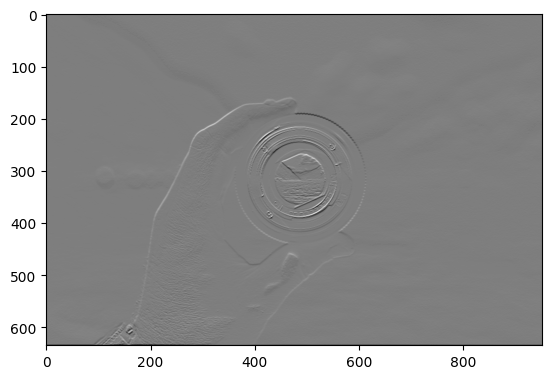

In [13]:
sobel_space = sobel(gray, kernel_y, data_type = np.float64)
show(sobel_space)
print(np.min(sobel_space))
print(np.max(sobel_space))

## Edge Negative Oy

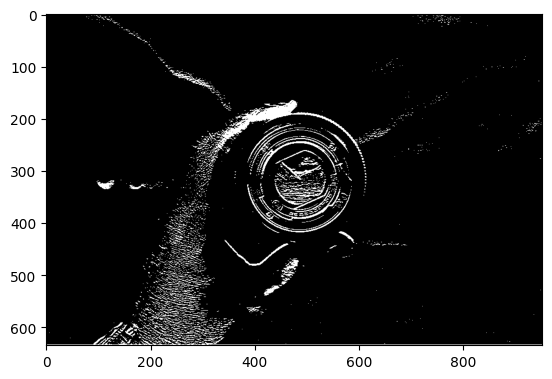

In [14]:
_, edge_negative = cv2.threshold(sobel_space, -30 , 255, cv2.THRESH_BINARY_INV)
#edge_negative = threshold_range(sobel_space, 10,40)
show(edge_negative)

## Edge Positive Oy

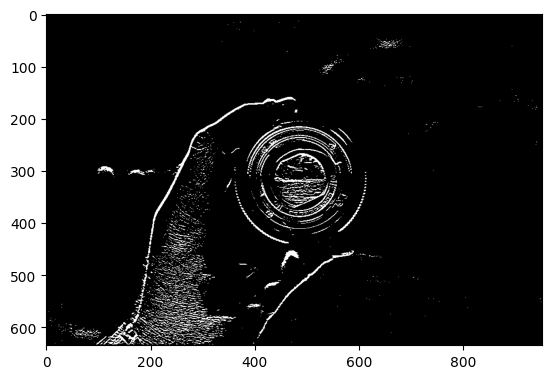

In [15]:
_, edge_positive = cv2.threshold(sobel_space, 30 , 255, cv2.THRESH_BINARY)
#edge_negative = threshold_range(sobel_space, 10,40)
show(edge_positive)

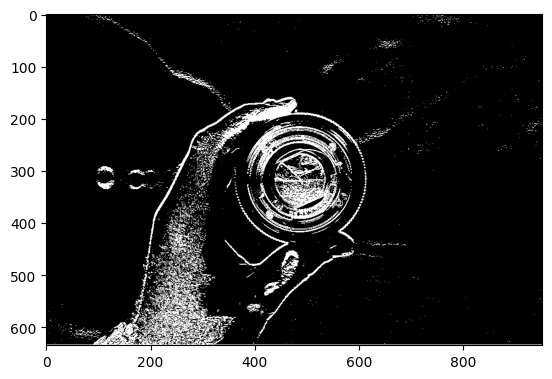

In [16]:
edeg_oy = cv2.bitwise_or(edge_positive, edge_negative)
show(edeg_oy)

## Combine 

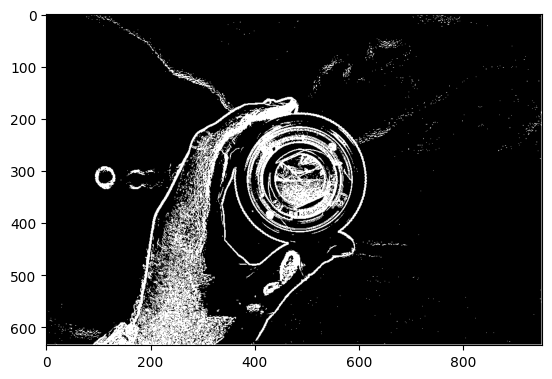

In [17]:
edge = cv2.bitwise_or(edeg_oy, edge_ox)
show(edge)


In [19]:
from function import SelectShape, SelectShapeStd

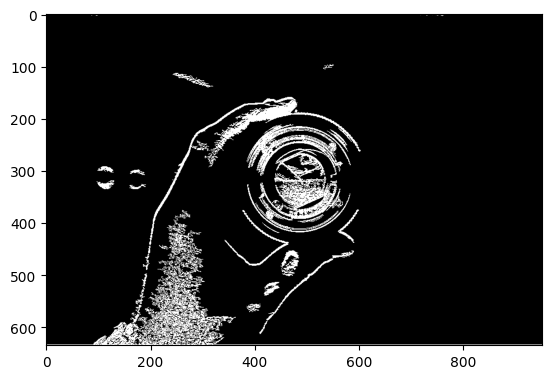

In [ ]:
result,list_region, _  = SelectShape(edge.astype(np.uint8), 50,50000, feature= "area")
show(result)

In [ ]:

def ErodeCircle(region , radius):
    
    mask = cv2.getStructuringElement(cv2.MORPH_CROSS, ksize = (2*radius + 1, 2*radius + 1))
    erosion = cv2.erode(region, mask , iterations = 1, borderType = cv2.BORDER_DEFAULT, borderValue = 0)
    return erosion 

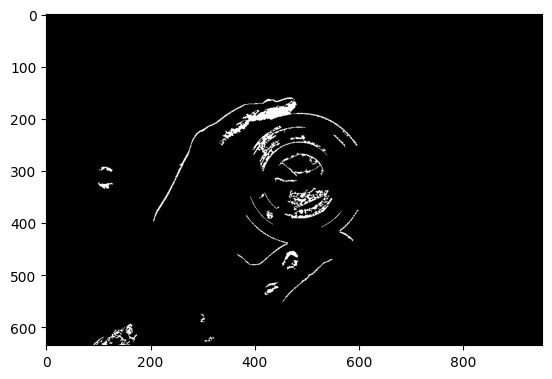

In [ ]:
erode = ErodeCircle(edge, 1)
result,list_region, _  = SelectShape(erode.astype(np.uint8), 50,50000, feature= "area")
show(result)

# **Canny**

1. Gaussian Filter
2. Sobel
3. Non-max Suppression
4. Double Threshold

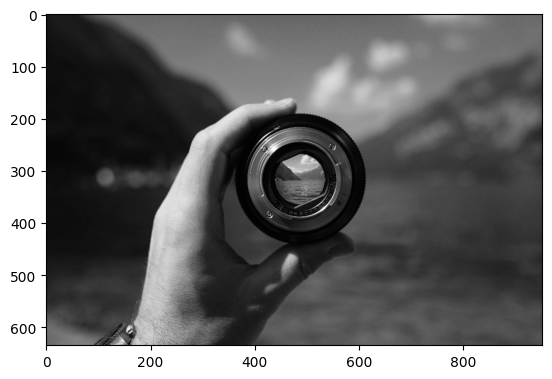

In [32]:
gray = cv2.imread("images/lens.png",0)
show(gray)

# Gaussian Filter

In [22]:
kernel_gaussian = 1 / 159 *  np.array([
    [2,4,5,4,2],
    [4,9,12,9,4],
    [5,12,15,12,5],
    [4,9,12,9,4],
    [5,12,15,12,5]
])
kernel_gaussian

array([[0.01257862, 0.02515723, 0.03144654, 0.02515723, 0.01257862],
       [0.02515723, 0.05660377, 0.0754717 , 0.05660377, 0.02515723],
       [0.03144654, 0.0754717 , 0.09433962, 0.0754717 , 0.03144654],
       [0.02515723, 0.05660377, 0.0754717 , 0.05660377, 0.02515723],
       [0.03144654, 0.0754717 , 0.09433962, 0.0754717 , 0.03144654]])

In [29]:
def gaussianblur(gray,kernel_gaussian):
    
    kernel_size = kernel_gaussian.shape[0]
    
    padding = kernel_size // 2 
    
    gray_padding = add_padding(gray,padding )
    
    gaussianed = np.zeros((gray.shape),dtype = np.float64)
    
    for y in range(gray.shape[0]):
        for x in range(gray.shape[1]):
            s = 0.0
            for i in range(kernel_size):
                for j in range(kernel_size):
                    s += np.float64(gray_padding[y+i, x+j]) * np.float64(kernel_gaussian[i,j])
                    
            gaussianed[y,x] = s
            
    return  gaussianed.astype(np.uint8)
        
    
    

In [30]:
gaussianed = gaussianblur(gray, kernel_gaussian)

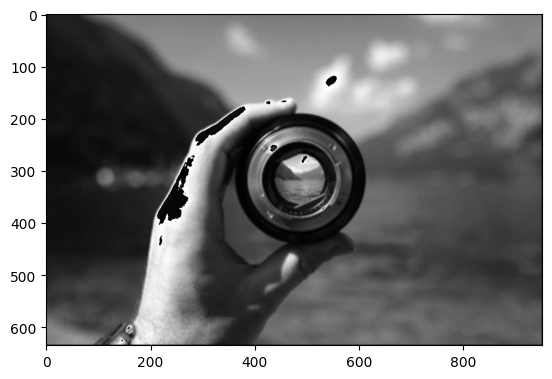

In [31]:
show(gaussianed)

## Sobel (gradient manitude, gradient direction ) 

0.0
1005.015422767233


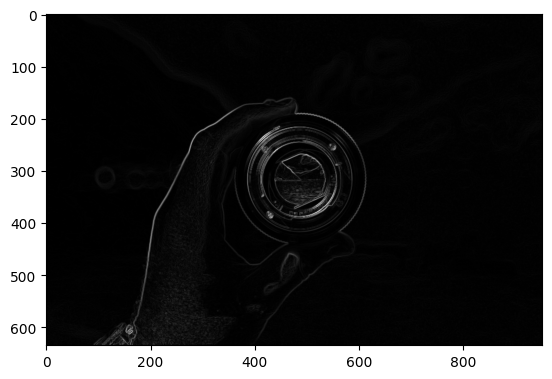

In [37]:
sobel_x = cv2.Sobel(gray,cv2.CV_64F, 1,0, 3 )
sobel_y = cv2.Sobel(gray,cv2.CV_64F, 0,1, 3 )

gradient_manitute = np.sqrt(sobel_x**2 + sobel_y**2)
show(gradient_manitute)
print(np.min(gradient_manitute))
print(np.max(gradient_manitute))

0
255


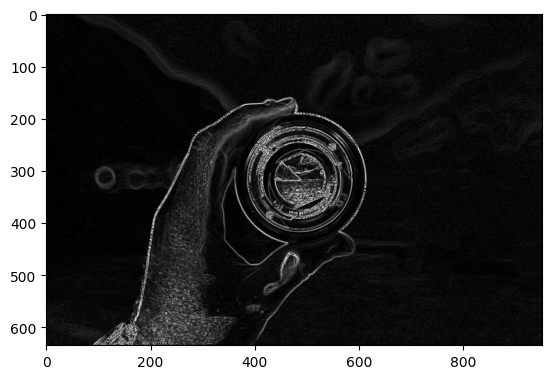

In [40]:
gradient_manitute_uint8 = gradient_manitute.astype(np.uint8)
print(np.min(gradient_manitute_uint8))
print(np.max(gradient_manitute_uint8))
show(gradient_manitute_uint8)

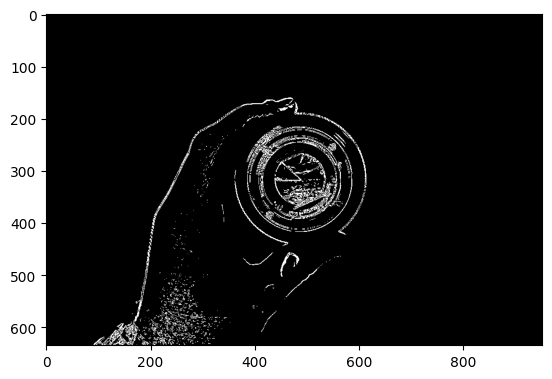

In [45]:
_, threshold = cv2.threshold(gradient_manitute_uint8, 100, 255, cv2.THRESH_BINARY)
show(threshold)

In [ ]:
show(sobel_x)
print(np.min(sobel_x))
print(np.max(sobel_x))

In [51]:
gradient_direction  = np.arctan2(sobel_y, sobel_x)
print(gradient_direction.shape)
print(gray.shape)
print(gradient_manitute.shape)

(635, 952)
(635, 952)
(635, 952)


## Non-max Suppression

In [63]:
def non_max_suppression(manitude, direction ):
    
    height, widht = manitude.shape[0], manitude.shape[1]
    
    edge_posible = np.zeros((height, widht), dtype = np.float64)
    
    angle =  direction * 180.0  / np.pi # radian -> degree
    
    angle[0<0] += 180 # Normalization [0:180]
    
    for y in range(1,height - 1):
        for x in range(1, widht - 1):
            
            a = 255
            b = 255
            # Direction 1
            if (0<= angle[y,x] <=22.5) or (157.5 <= angle[y,x] <= 180):
                a = manitude[y,x-1]
                b = manitude[y,x+1]
                
            # Direction 2
            if 22.5 <= angle[y,x] <= 67.5:
                a = manitude[y+1,x-1]
                b = manitude[y-1,x+1]
            
            
            # Direction 3
            if 67.5<= angle[y,x] <= 112.5:
                a = manitude[y-1,x]
                b = manitude[y+1,x]
                
            # Direction 4 
            if 112.5<= angle[y,x] <= 157.5:
                a = manitude[y-1,x-1]
                b = manitude[y+1,x+1]   
                
            
            if manitude[y,x] > a and manitude[y,x] >b :
                edge_posible[y,x] = manitude[y,x]
            else:
                edge_posible[y,x]  = 0
            
    return edge_posible
    

In [64]:
edge_posible = non_max_suppression(gradient_manitute, gradient_direction)

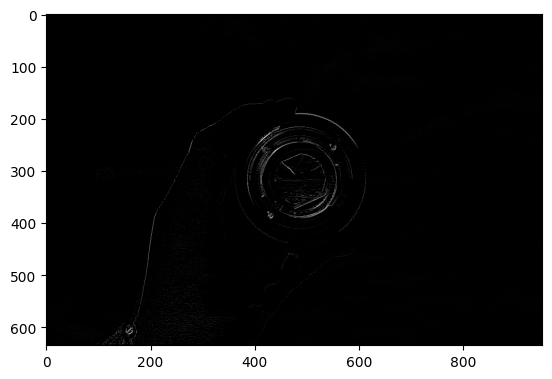

In [65]:
show(edge_posible)

## Double threshold

In [68]:

strong_edge = np.array([
    [False, False, False],
    [False,False,False]
])

if strong_edge.any():
    print(f'co gia tri True')
else:
    print(f'ko co gia tri True')

ko co gia tri True


In [71]:
def double_threshold(edge_posible, low_threshold, high_threshold):
    #strong_edge, weak_edge
    
    strong_edge = (edge_posible > high_threshold)
    weak_edge = (edge_posible >= low_threshold) & (edge_posible <=high_threshold)
    
    for y in range(1, edge_posible.shape[0] - 1):
        for x in range(1, edge_posible.shape[1] - 1):
            
            if weak_edge[y, x]:
                if strong_edge[y-1:y+1 , x-1:x+1].any():
                    strong_edge[y,x] = True
                    
                else:
                    weak_edge[y,x] = False

    return strong_edge
    

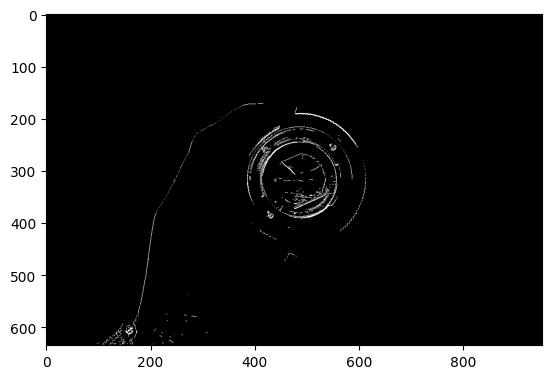

In [78]:
strong_edge  = double_threshold(edge_posible, 70, 200)
show(strong_edge)